# Segmentation map으로 도로 이미지 만들기

| 평가문항 | 상세기준 |
| :---: | :---: |
| 1. pix2pix 모델 학습을 위해 필요한 데이터셋을 적절히 구축하였다. | 데이터 분석 과정 및 한 가지 이상의 augmentation을 포함한 데이터셋 구축 과정이 체계적으로 제시되었다. |
| 2. pix2pix 모델을 구현하여 성공적으로 학습 과정을 진행하였다. | U-Net generator, discriminator 모델 구현이 완료되어 train_step이 안정적으로 진행됨을 확인하였다. |
| 3. 학습 과정 및 테스트에 대한 시각화 결과를 제출하였다. | 10 epoch 이상의 학습을 진행한 후 최종 테스트 결과에서 진행한 epoch 수에 걸맞은 정도의 품질을 확인하였다. |

## 개념 정리

Conditional Generative Adversarial Nets (cGAN) 은 내가 원하는 종류의 이미지를 생성하고자 할 때 GAN이 가진 생성 과정의 불편함을 해소하여, 내가 원하는 종류의 이미지를 생성할 수 있도록 고안된 방법임.


cGAN의 목적함수는 GAN의 목적함수와 비교시,D(x)와 G(z)가 각각 D(x∣y), G(z∣y)로 바뀌었음.

여기서 함께 입력하는 y는 어떠한 정보여도 상관없으며, MNIST 데이터셋을 학습시키는 경우 y는 0~9 까지의 label 정보가 됨.
Generator가 어떠한 노이즈 z를 입력받았을 때, 특정 조건 y가 함께 입력되기 때문에, y를 통해 z를 어떠한 이미지로 만들어야 할지에 대한 방향을 제어할 수 있게 됨.

조금 다르게 표현하면 y가 임의 노이즈 입력인 z의 가이드라고 할 수 있음.

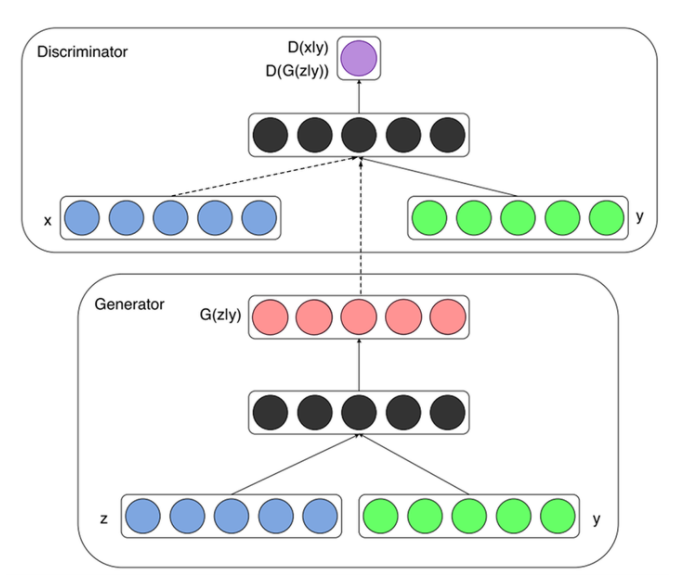

#### Generator 
노이즈 z(파란색)와 추가 정보 y(녹색)을 함께 입력받아 Generator 내부에서 결합되어 representation(검정색)으로 변환되며 가짜 데이터 G(z∣y)G(z∣y)를 생성함. MNIST나 CIFAR-10 등의 데이터셋에 대해 학습시키는 경우 y는 레이블 정보이며, 일반적으로 one-hot 벡터를 입력으로 넣게됨.

#### Discriminator 
실제 데이터 x와 Generator가 생성한 가짜 데이터 G(z∣y)G(z∣y)를 각각 입력받으며, 마찬가지로 y정보가 각각 함께 입력되어 진짜와 가짜를 식별함. MNIST나 CIFAR-10 등의 데이터셋에 대해 학습시키는 경우 실제 데이터 x와 y는 알맞은 한 쌍("7"이라 쓰인 이미지의 경우 레이블도 7)을 이뤄야 하며, 마찬가지로 Generator에 입력된 y와 Discriminator에 입력되는 y는 동일한 레이블을 나타내야 함.


Pix2Pix는 기존 노이즈 입력을 이미지로 변환하는 일반적인 GAN이 아니라, 이미지를 입력으로 하여 원하는 다른 형태의 이미지로 변환시킬 수 있는 GAN 모델임.


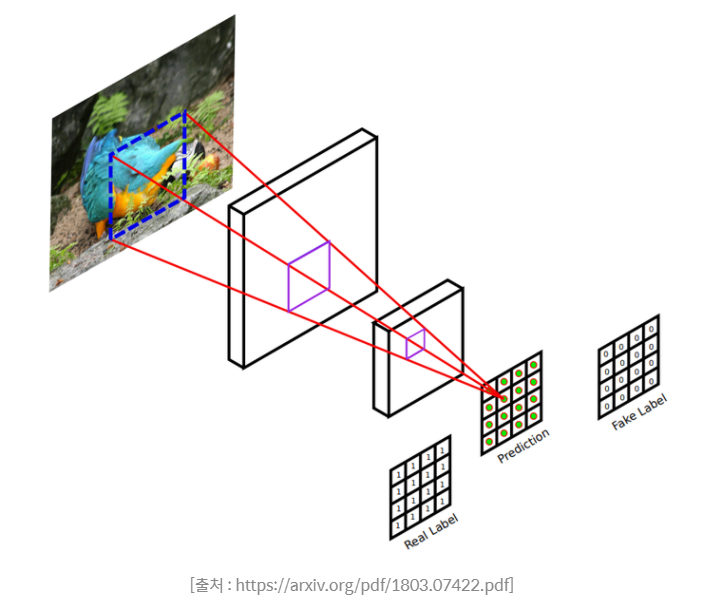

DCGAN의 discriminator은 하나의 전체 이미지에 대해 하나의 확률 값만을 도출하는 데, Pix2Pix에서 discriminator은 이미지가 Discriminator의 입력으로 들어오면, convolution 레이어를 거쳐 확률 값을 나타내는 최종 결과를 생성하는데, 그 결과는 하나의 값이 아닌 여러 개의 값을 갖게됨. (위 그림의 Prediction은 16개의 값을 가지고 있음). 위 그림에서 입력 이미지의 파란색 점선은 여러 개의 출력 중 하나의 출력을 계산하기 위한 입력 이미지의 receptive field 영역을 나타내고 있으며, 전체 영역을 다 보는 것이 아닌 일부 영역(파란색 점선)에 대해서만 진짜/가짜를 판별하는 하나의 확률 값을 도출한다는 것임.

이런 방식으로 서로 다른 영역에 대해 진짜/가짜를 나타내는 여러 개의 확률 값을 계산할 수 있으며 이 값을 평균하여 최종 Discriminator의 출력을 생성함. 이러한 방법은 이미지의 일부 영역(patch)을 이용한다고 하여 PatchGAN이라고 불림. 일반적으로 이미지에서 거리가 먼 두 픽셀은 서로 연관성이 거의 없기 때문에 특정 크기를 가진 일부 영역에 대해서 세부적으로 진짜/가짜를 판별하는 것이 Generator로 하여금 더 진짜 같은 이미지를 만들도록 하는 방법임.

# 데이터 준비하기

In [1]:
import os

data_path = os.getenv('HOME')+'/aiffel/conditional_generation/cityscapes/train/'
print("number of train examples :", len(os.listdir(data_path)))

number of train examples : 1000


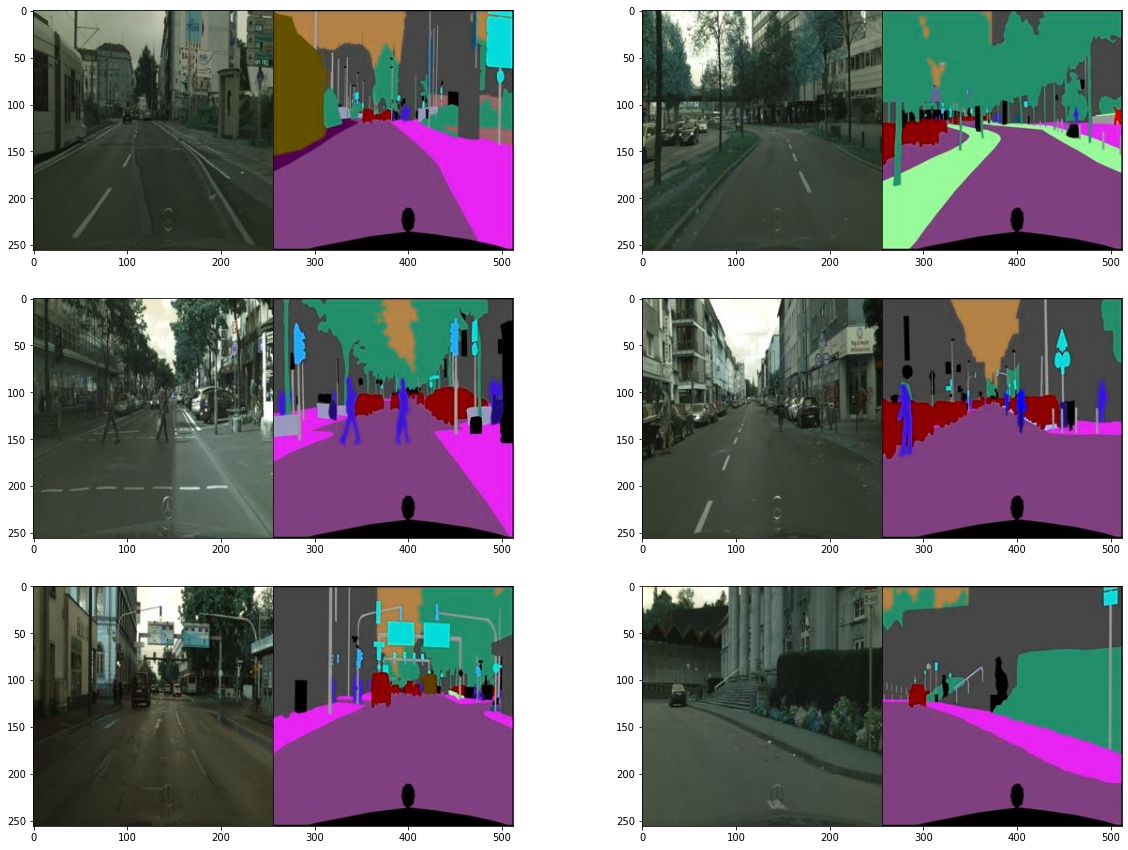

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(20,15))
for i in range(1, 7):
    f = data_path + os.listdir(data_path)[np.random.randint(800)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3,2,i)
    plt.imshow(img)

In [3]:
f = data_path + os.listdir(data_path)[0]
img = cv2.imread(f, cv2.IMREAD_COLOR)
print(img.shape)

(256, 512, 3)


##### 이미지 나누기

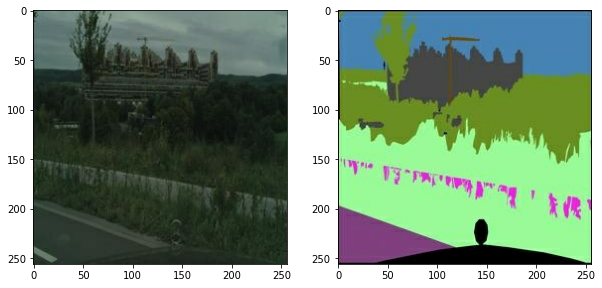

In [4]:
import tensorflow as tf

def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

def denormalize(x):
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1] // 2
    sketch = img[:, :w, :] 
    sketch = tf.cast(sketch, tf.float32)
    colored = img[:, w:, :] 
    colored = tf.cast(colored, tf.float32)
    return normalize(sketch), normalize(colored)

f = data_path + os.listdir(data_path)[1]
sketch, colored = load_img(f)

plt.figure(figsize=(10,7))
plt.subplot(1,2,1); plt.imshow(denormalize(sketch))
plt.subplot(1,2,2); plt.imshow(denormalize(colored))

## Data augmentation

In [5]:
from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation

@tf.function() # 빠른 텐서플로 연산을 위해 @tf.function()을 사용합니다. 
def apply_augmentation(sketch, colored):
    stacked = tf.concat([sketch, colored], axis=-1)
    
    _pad = tf.constant([[30,30],[30,30],[0,0]])
    if tf.random.uniform(()) < .5:
        padded = tf.pad(stacked, _pad, "REFLECT")
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.)

    out = image.random_crop(padded, size=[256, 256, 6])
    
    out = image.random_flip_left_right(out)
    out = image.random_flip_up_down(out)
    
    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = image.rot90(out, k=degree)
    
    return out[...,:3], out[...,3:]   


apply_augmentation 함수는 스케치 및 채색된 2개 이미지를 입력으로 받아 여러 가지 연산을 두 이미지에 동일하게 적용함.

두 이미지가 채널 축으로 연결됨. (tf.concat). 두 이미지가 각각 3채널인 경우 6채널이 됨.

1.의 결과에 각 50% 확률로 Refection padding 또는 constant padding이 30픽셀의 pad width 만큼 적용됨. (tf.pad)

2.의 결과에서 (256,256,6) 크기를 가진 이미지를 임의로 잘라냄. (tf.image.random_crop)

3.의 결과를 50% 확률로 가로로 뒤집음. (tf.image.random_flip_left_right)

4.의 결과를 50% 확률로 세로로 뒤집음. (tf.image.random_flip_up_down)

5.의 결과를 50% 확률로 회전시킴. (tf.image.rot90)

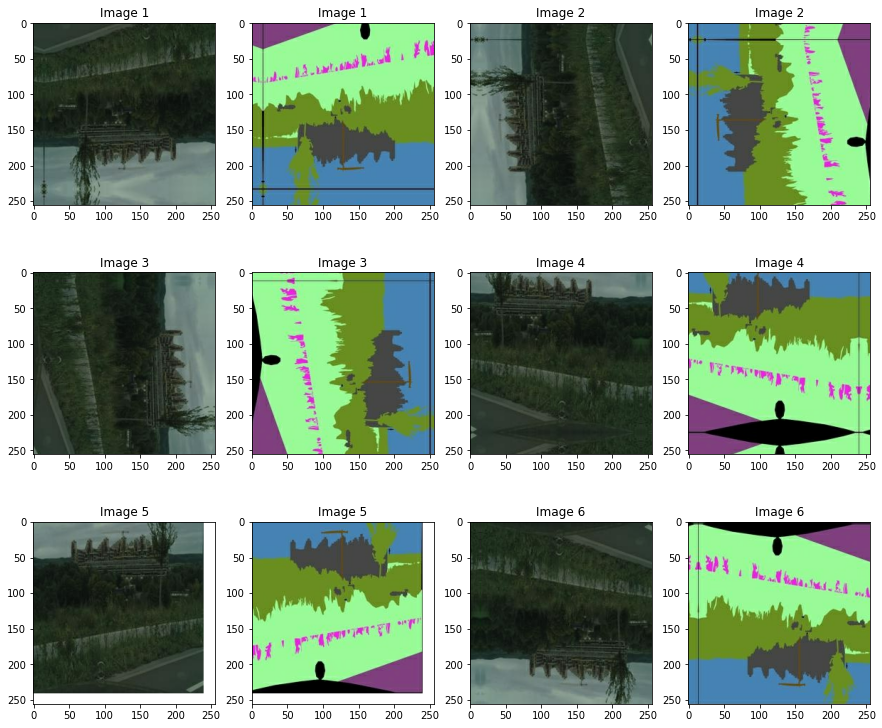

In [6]:
plt.figure(figsize=(15,13))
img_n = 1
for i in range(1, 13, 2):
    augmented_sketch, augmented_colored = apply_augmentation(sketch, colored)
    
    plt.subplot(3,4,i)
    plt.imshow(denormalize(augmented_sketch)); plt.title(f"Image {img_n}")
    plt.subplot(3,4,i+1); 
    plt.imshow(denormalize(augmented_colored)); plt.title(f"Image {img_n}")
    img_n += 1

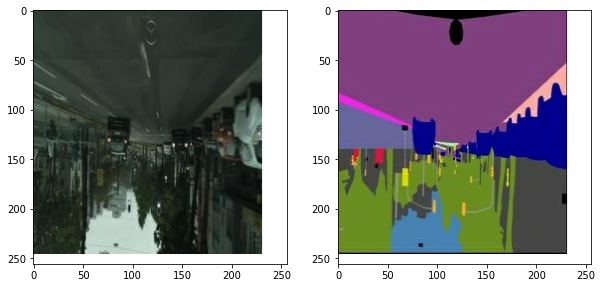

In [7]:
from tensorflow import data

def get_train(img_path):
    sketch, colored = load_img(img_path)
    sketch, colored = apply_augmentation(sketch, colored)
    return sketch, colored

train_images = data.Dataset.list_files(data_path + "*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(4)

sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
sketch, colored = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(sketch[0].astype(np.uint8))
plt.subplot(1,2,2); plt.imshow(colored[0].astype(np.uint8))

- encoder의 "C64"는 어떠한 하이퍼파라미터를 가진 레이어들의 조합이 됨.

 64개의 4x4 필터에 stride 2를 적용한 Convolution → 0.2 slope의 LeakyReLU (BatchNorm을 사용하지 않는 것이 권고됨.)


- decoder의 "CD512"는 어떠한 하이퍼파라미터를 가진 레이어들의 조합
512개의 4x4 필터에 stride 2를 적용한 (Transposed) Convolution → BatchNorm → 50% Dropout → ReLU

## U net을 활용하여 Generator 구성하기

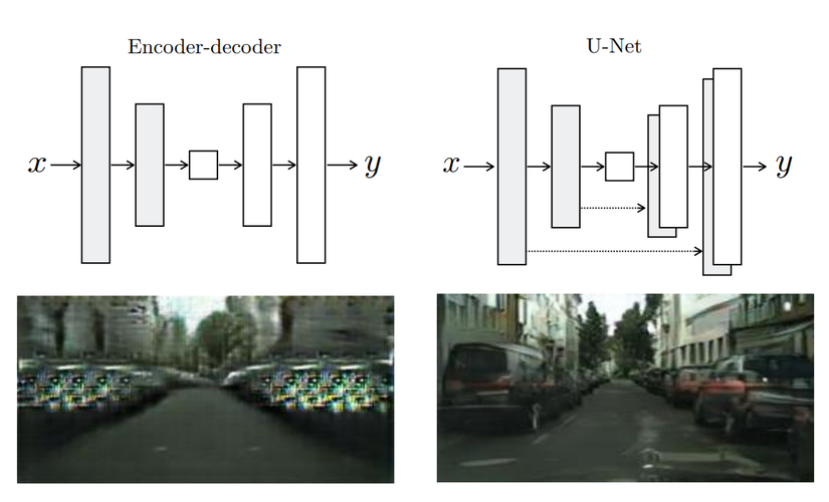


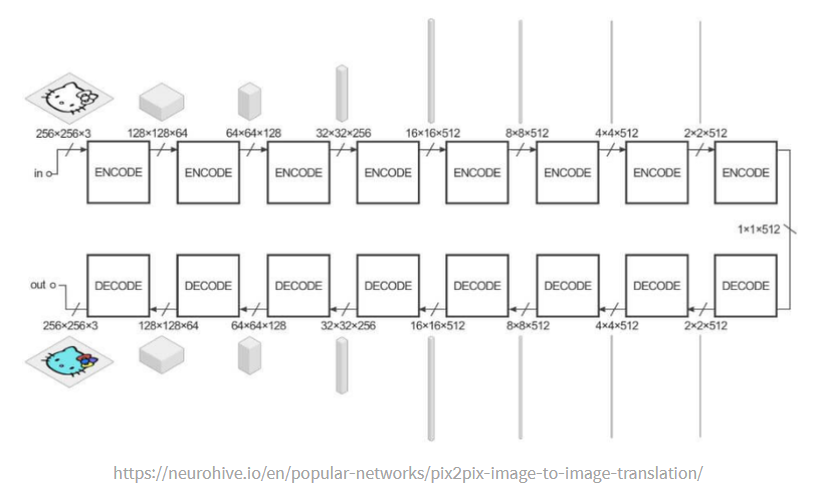

Convolution → BatchNorm → LeakyReLU"의 3개 레이어로 구성된 기본적인 블록을 아래와 같이 하나의 레이어로 만들었음

In [8]:
from tensorflow.keras import layers, Input, Model

class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu = layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

    
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

__init__() 메서드에서 n_filters, use_bn를 설정하여 사용할 필터의 개수와 BatchNorm 사용 여부를 결정할 수 있음.
이 외 Convolution 레이어에서 필터의 크기(=4) 및 stride(=2)와 LeakyReLU 활성화의 slope coefficient(=0.2)는 모든 곳에서 고정되어 사용하므로 각각의 값을 지정하였음.
Encoder에 사용할 기본 블록을 구성했으니 이 블록을 여러 번 가져다 사용하면 아래와 같이 쉽게 Encoder를 구성할 수 있음.

각 블록을 거치면서 사용할 필터의 개수를 filters라는 리스트에 지정해 두었으며, blocks이라는 리스트에는 사용할 블록들을 정의해 넣어두고, call() 메서드에서 차례대로 블록들을 통과하게함. 

In [9]:
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        features = features[:-1]
                    
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

call() 내에서 features = features[:-1] 

- Skip connection을 위해 만들어진 features 리스트에는 Encoder 내 각 블록의 출력이 들어있는데, Encoder의 마지막 출력(feature리스트 의 마지막 항목)은 Decoder로 직접 입력되므로 skip connection의 대상이 아닙니다.

Decoder 연산 부분에서 features[::-1]

- Skip connection은 Encoder 내 첫 번째 블록의 출력이 Decoder의 마지막 블록에 연결되고, Encoder 내 두 번째 블록의 출력이 Decoder의 뒤에서 2번째 블록에 연결되는.. 등 대칭을 이룹니다(맨 위 U-Net 구조 사진 참고). features에는 Encoder 블록들의 출력들이 순서대로 쌓여있고, 이를 Decoder에서 차례대로 사용하기 위해서 features의 역순으로 연결합니다.

In [10]:
UNetGenerator().get_summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
encode_block (EncodeBlock)      (None, 128, 128, 64) 3072        input_1[0][0]                    
__________________________________________________________________________________________________
encode_block_1 (EncodeBlock)    (None, 64, 64, 128)  131584      encode_block[0][0]               
__________________________________________________________________________________________________
encode_block_2 (EncodeBlock)    (None, 32, 32, 256)  525312      encode_block_1[0][0]             
______________________________________________________________________________________________

예시) 아래와 같은 데이터 A, B가 있을 때,

데이터 A 크기 : (32,128,128,200) #(batch, width, height, channel)
데이터 B 크기 : (32,128,128,400) #(batch, width, height, channel)

skip connection은 layers.Concatenate() 결과의 크기
-> (128,128,600) layers.Concatenate() 내에 별다른 설정이 없다면 가장 마지막 축(채널 축)을 기준으로 서로 연결됨.

In [11]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 

__init__() 에서 필요한 만큼 많은 설정을 가능하게끔 함. 

필터의 수(n_filters), 필터가 순회하는 간격(stride), 출력 feature map의 크기를 조절할 수 있도록 하는 패딩 설정(custom_pad), BatchNorm의 사용 여부(use_bn), 활성화 함수 사용 여부(act)가 설정 가능함.

위에서 만든 DiscBlock의 설정을 다음과 같이 하여 DiscBlock(n_filters=64, stride=1, custom_pad=True, use_bn=True, act=True) 으로 생성된 블록에 (width, height, channel) = (128, 128, 32) 크기가 입력된다면, 

1) 패딩 레이어 통과 layers.ZeroPadding2D() → width 및 height의 양쪽 면에 각각 1씩 패딩되어 총 2만큼 크기가 늘어남.  출력 : (130,130,32)

2) Convolution 레이어 통과 layers.Conv2D(64,4,1,"valid") → 패딩하지 않고 필터 크기 4 및 간격(stride) 1의 convolution 레이어를 통과하면 width 및 height 가 3씩 줄어듬.. 이는 OutSize=(InSize+2∗PadSize−FilterSize)/Stride+1 의 식으로 계산할 수 있음. 채널 수는 사용한 필터 개수와 같음. 출력 : (127,127,64)

3) BatchNormalization 레이어 통과 layers.BatchNormalization() → (127,127,64)

4) LeakyReLU 활성화 레이어 통과 layers.LeakyReLU(0.2) → (127,127,64)

In [12]:
inputs = Input((128,128,32))
out = layers.ZeroPadding2D()(inputs)
out = layers.Conv2D(64, 4, 1, "valid", use_bias=False)(out)
out = layers.BatchNormalization()(out)
out = layers.LeakyReLU(0.2)(out)

Model(inputs, out).summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 32)]    0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 130, 130, 32)      0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 127, 127, 64)      32768     
_________________________________________________________________
batch_normalization_15 (Batc (None, 127, 127, 64)      256       
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 127, 127, 64)      0         
Total params: 33,024
Trainable params: 32,896
Non-trainable params: 128
_________________________________________________________________


## Discriminator 구성하기

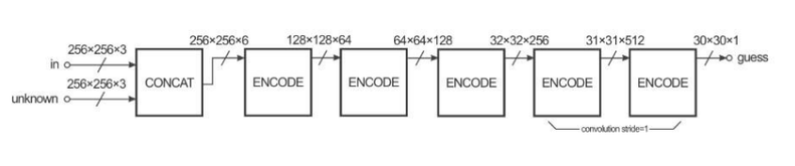

Discriminator는 2개 입력(위 그림의 "in", "unknown")을 받아 연결(CONCAT)한 후, ENCODE 라고 쓰인 5개의 블록을 통과함. 
이 중 마지막 블록을 제외한 4개 블록은 관련 논문에서 표기된 "C64-C128-C256-C512"에 해당하며, 마지막은 1(채널)차원 출력을 위한 블록이 추가되었음.

최종적으로 출력되는 크기는 (30,30,1) 이며, 위 그림의 출력 이전의 2개의 ENCODE 블록을 보면 각각의 출력 크기가 32, 31, 30으로 1씩 감소하는 것을 알 수 있음.

추가적으로 위 그림에서 최종 출력 크기가 (30,30,1)이 되어야 하는 이유는 앞서 Discriminator에 대해 알아봤던 70x70 PatchGAN을 사용했기 때문임. 최종 (30,30) 출력에서 각 픽셀의 receptive field 크기를 (70,70)으로 맞추기 위해 Discriminator의 출력 크기를 (30,30) 크기로 강제로 맞추는 과정임.

1.(128,128,32) 크기의 입력이 layers.ZeroPadding2D()를 통과하면, width 및 height의 양쪽 면에 각각 1씩 패딩되어 총 2만큼 크기가 늘어남. 출력 : (130,130,32)

2.패딩하지 않고 필터 크기 4 및 간격(stride) 1의 convolution 레이어를 통과하면 width 및 height 가 3씩 줄어듬. 이는 OutSize=(InSize+2∗PadSize−FilterSize)/Stride+1 의 식으로 계산할 수 있음. 채널 수는 사용한 필터 개수와 같음. 출력 : (127,127,64)

3.이 외 다른 레이어(BatchNorm, LeakyReLU)는 출력의 크기에 영향을 주지 않음

In [13]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.block1 = layers.Concatenate()
        self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        self.sigmoid = layers.Activation("sigmoid")
        
        # filters = [64,128,256,512,1]
        # self.blocks = [layers.Concatenate()]
        # for i, f in enumerate(filters):
        #     self.blocks.append(DiscBlock(
        #         n_filters=f,
        #         strides=2 if i<3 else 1,
        #         custom_pad=False if i<3 else True,
        #         use_bn=False if i==0 and i==4 else True,
        #         act=True if i<4 else False
        #     ))
    
    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()

In [14]:
Discriminator().get_summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate_7 (Concatenate)     (None, 256, 256, 6)  0           input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
disc_block (DiscBlock)          (None, 128, 128, 64) 6144        concatenate_7[0][0]        

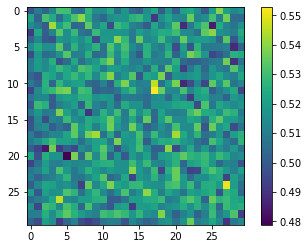

In [15]:
x = tf.random.normal([1,256,256,3])
y = tf.random.uniform([1,256,256,3])

disc_out = Discriminator()(x, y)
plt.imshow(disc_out[0, ... ,0])
plt.colorbar()

In [16]:
from tensorflow.keras import losses

bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)

Generator의 손실 함수 (위 코드의 get_gene_loss)는 총 3개의 입력이 있음.

이 중 fake_disc는 Generator가 생성한 가짜 이미지를 Discriminator에 입력하여 얻어진 값이며, 실제 이미지를 뜻하는 "1"과 비교하기 위해 tf.ones_like()를 사용하며 또한 L1 손실을 계산하기 위해 생성한 가짜 이미지(fake_output)와 실제 이미지(real_output) 사이의 MAE(Mean Absolute Error)를 계산함.

Discriminator의 손실 함수 (위 코드의 get_disc_loss)는 2개의 입력이 있으며, 이들은 가짜 및 진짜 이미지가 Discriminator에 각각 입력되어 얻어진 값임. Discriminator는 실제 이미지를 잘 구분해 내야 하므로 real_disc는 "1"로 채워진 벡터와 비교하고, fake_disc는 "0"으로 채워진 벡터와 비교함.

In [17]:
from tensorflow.keras import optimizers

gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

In [18]:
@tf.function
def train_step(sketch, real_colored):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_colored = generator(sketch, training=True)
        # Discriminator 예측
        fake_disc = discriminator(sketch, fake_colored, training=True)
        real_disc = discriminator(sketch, real_colored, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_colored, real_colored, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

In [19]:
EPOCHS = 200

generator = UNetGenerator()
discriminator = Discriminator()

for epoch in range(1, EPOCHS+1):
    for i, (sketch, colored) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(sketch, colored)
                
        # 100회 반복마다 손실을 출력합니다.
        if (i+1) % 100 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

EPOCH[1] - STEP[100]                     
Generator_loss:1.1262                     
L1_loss:0.2771                     
Discriminator_loss:1.2746

EPOCH[1] - STEP[200]                     
Generator_loss:2.4976                     
L1_loss:0.1847                     
Discriminator_loss:1.2921

EPOCH[2] - STEP[100]                     
Generator_loss:1.7283                     
L1_loss:0.1898                     
Discriminator_loss:1.0791

EPOCH[2] - STEP[200]                     
Generator_loss:1.4273                     
L1_loss:0.2178                     
Discriminator_loss:0.8609

EPOCH[3] - STEP[100]                     
Generator_loss:1.0772                     
L1_loss:0.2481                     
Discriminator_loss:0.7322

EPOCH[3] - STEP[200]                     
Generator_loss:0.3814                     
L1_loss:0.2804                     
Discriminator_loss:1.4597

EPOCH[4] - STEP[100]                     
Generator_loss:1.6612                     
L1_loss:0.2047             

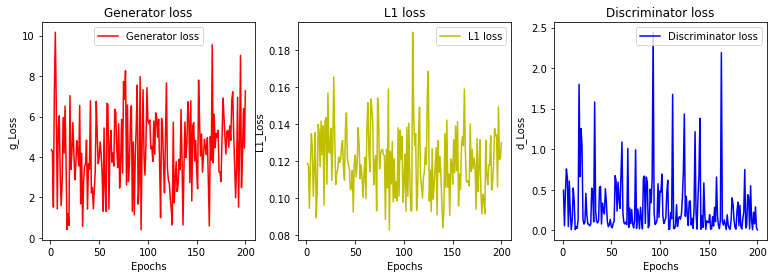

In [20]:
EPOCHS = 200
fig = plt.figure(figsize=(13,4))
g = []
l1 = []
d = []

for epoch in range(1, EPOCHS+1):
    for i, (sketch, colored) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(sketch, colored)
    g.append(g_loss.numpy())
    l1.append(l1_loss.numpy())
    d.append(d_loss.numpy())

epochs = range(1, len(g)+1)

ax1 = fig.add_subplot(1,3,1)
plt.plot(epochs, g, 'r', label='Generator loss')
plt.title('Generator loss')
plt.xlabel('Epochs')
plt.ylabel('g_Loss')
plt.legend()

ax2 = fig.add_subplot(1,3,2)
plt.plot(epochs, l1, 'y', label='L1 loss')
plt.title('L1 loss')
plt.xlabel('Epochs')
plt.ylabel('L1_Loss')
plt.legend()

ax3 = fig.add_subplot(1,3,3)
plt.plot(epochs, d, 'b', label='Discriminator loss')
plt.title('Discriminator loss')
plt.xlabel('Epochs')
plt.ylabel('d_Loss')
plt.legend()

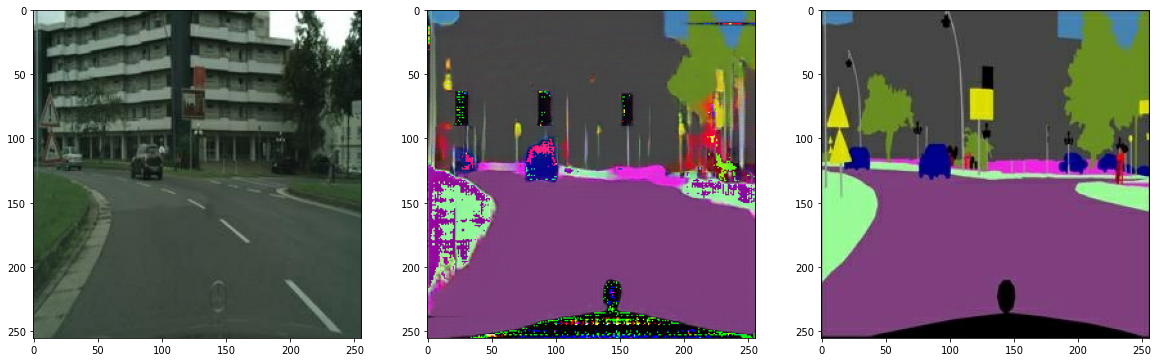

In [23]:
test_ind = 2
val_path = os.getenv('HOME')+'/aiffel/conditional_generation/cityscapes/val'

f = data_path + os.listdir(val_path)[test_ind]
sketch, colored = load_img(f)

pred = generator(tf.expand_dims(sketch, 0))
pred = denormalize(pred)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.imshow(denormalize(sketch))
plt.subplot(1,3,2); plt.imshow(pred[0])
plt.subplot(1,3,3); plt.imshow(denormalize(colored))

# Report



GAN 모델 이후로 U-net기반 conditional GAN 모델을 만들어봄.

기존 모델과 비교했을 때 U-net을 적용함으로써 더 좋은 결과물을 얻은 것을 확인 할 수 있으나 epoch 200에서는 결과과 만족스럽지는 못한 것 같음.
